In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';') 
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# check dist of target var
df.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

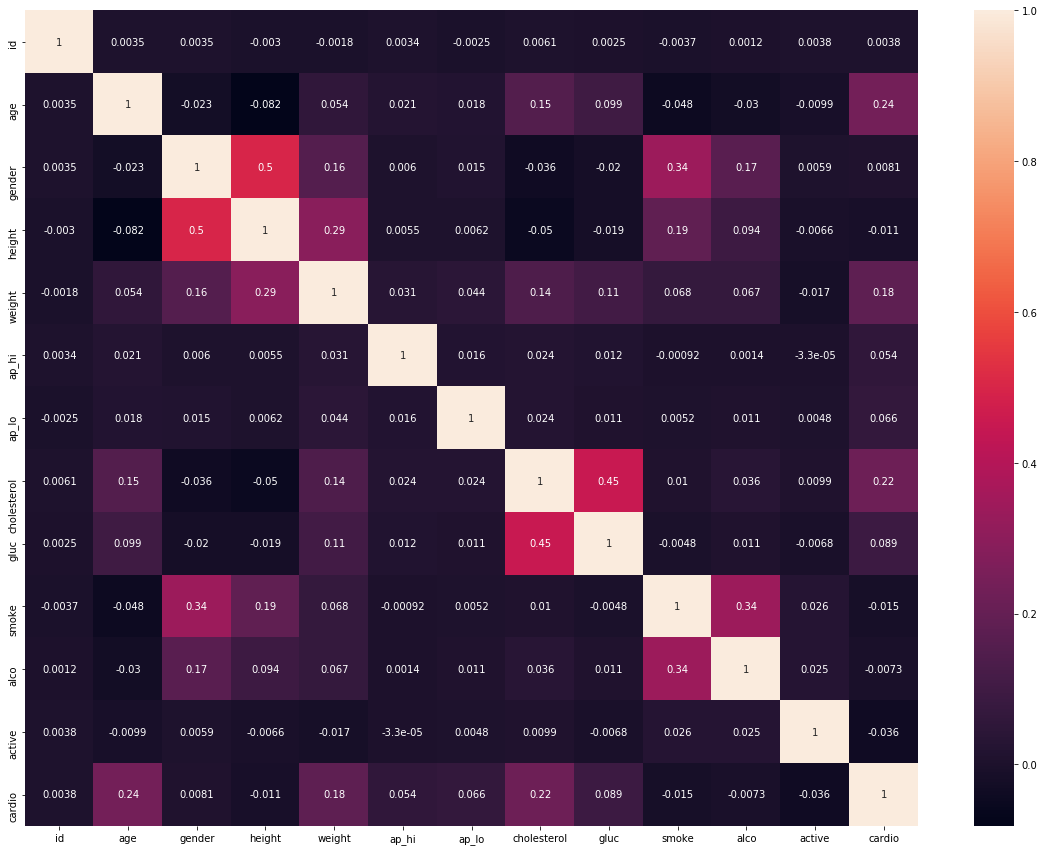

In [6]:
# check correlations
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)

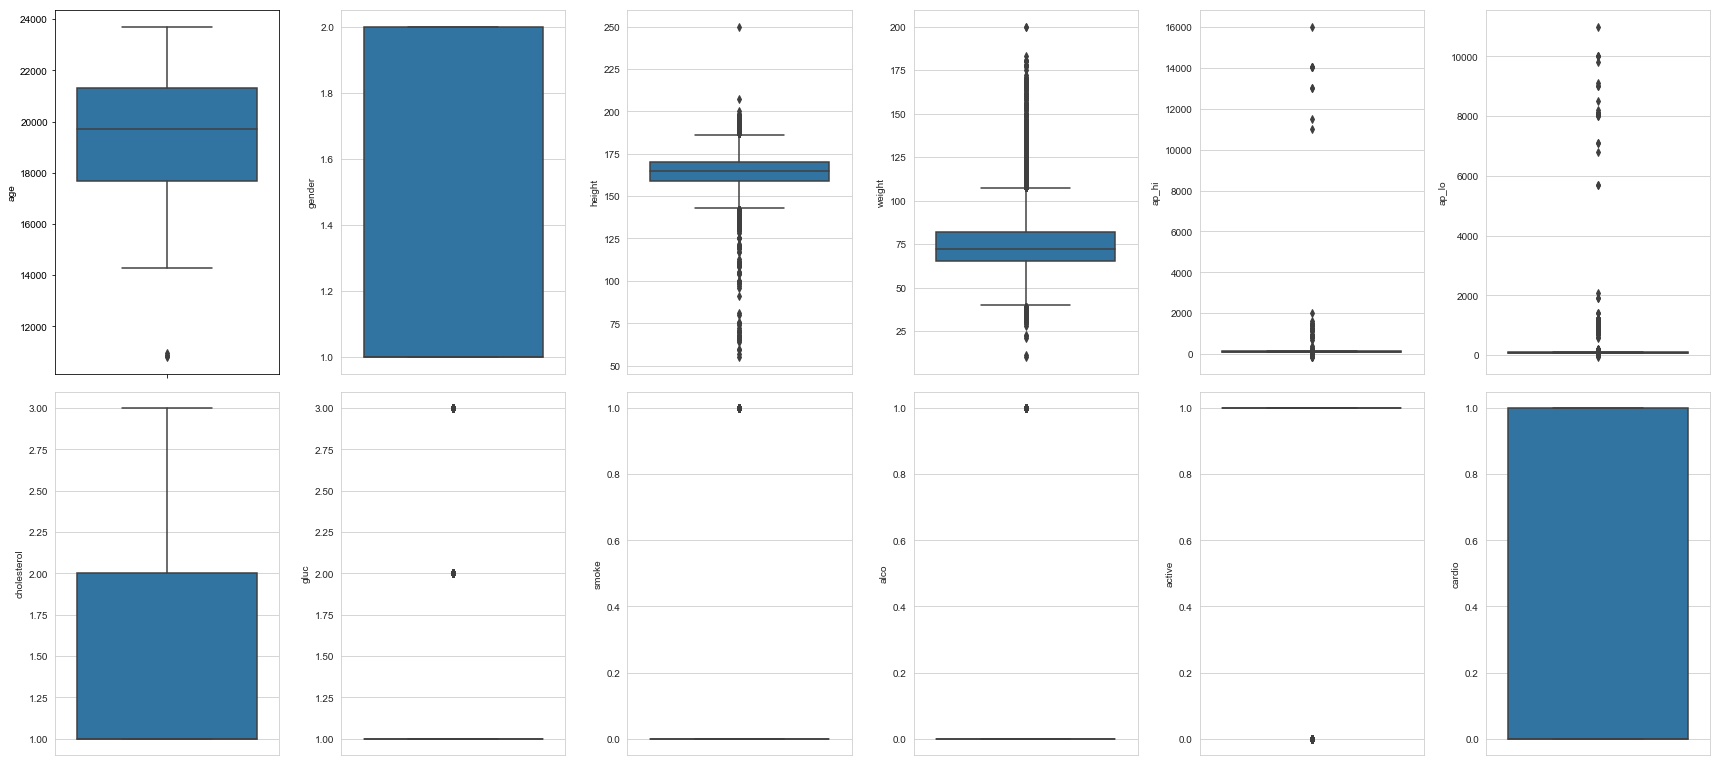

In [7]:
# check outliers

def check_outliers(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)/2
    number_of_rows = 2
    
    plt.figure(figsize=(4*number_of_columns,8*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],orient='v')
        plt.tight_layout()
        
check_outliers(df)

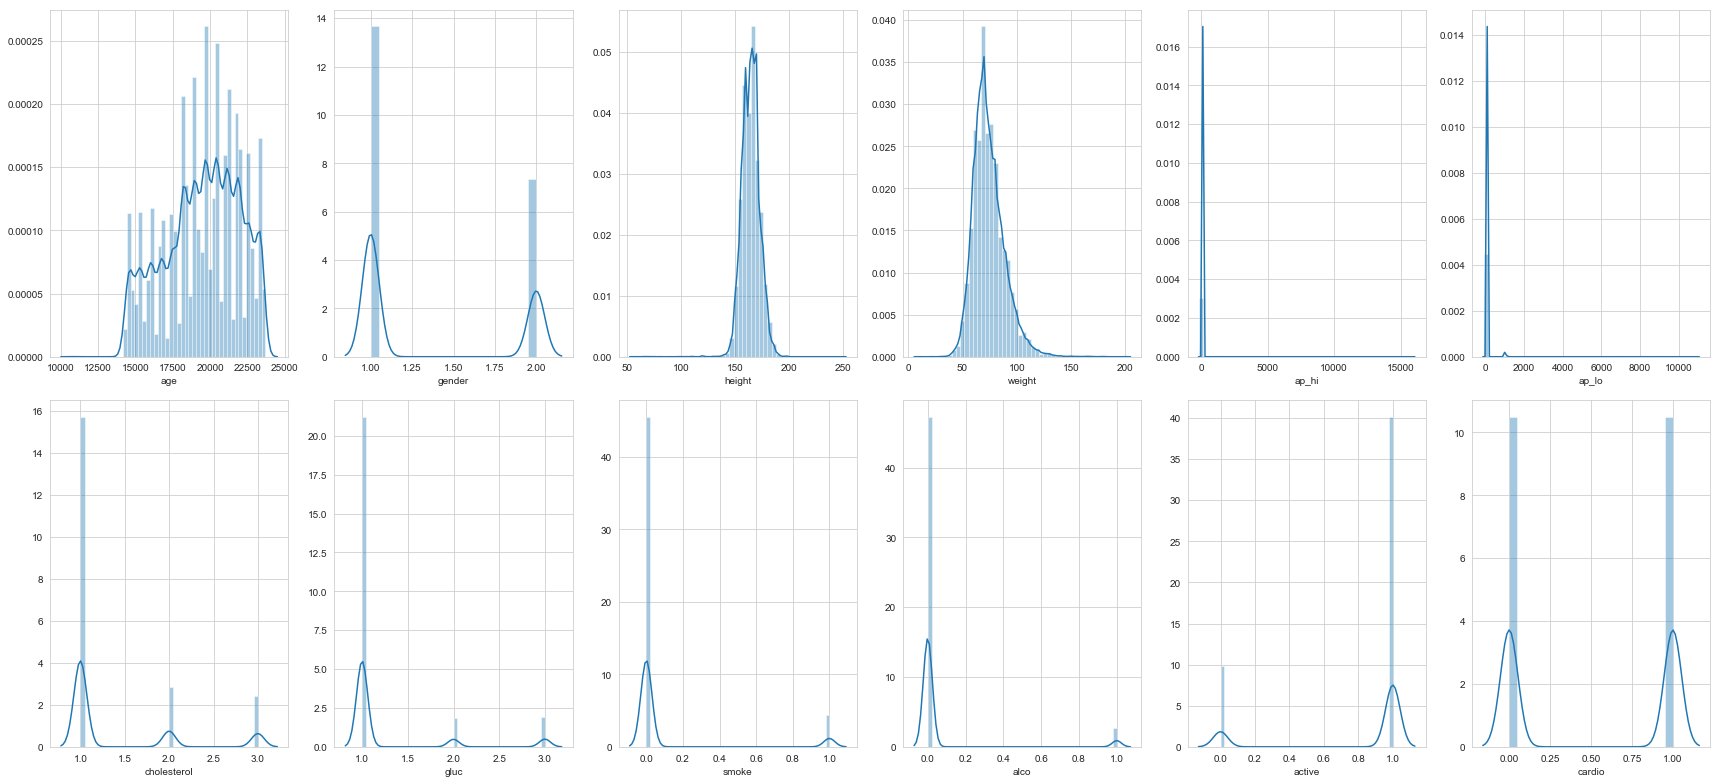

In [8]:
# check dist and skew
def check_dist(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)/2
    number_of_rows = 2
    
    plt.figure(figsize=(4*number_of_columns,8*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows+1,number_of_columns,i)
        sns.distplot(df[l[i]],kde=True) 
        plt.tight_layout()
        
check_dist(df)

In [9]:
# feel like there are ap_hi and ap_lo outliers- see boxplots
cleaned_df = df[df['ap_hi'] < 250]  
cleaned_df = cleaned_df[cleaned_df['ap_lo'] < 250] 

print(cleaned_df.shape)

(69007, 13)


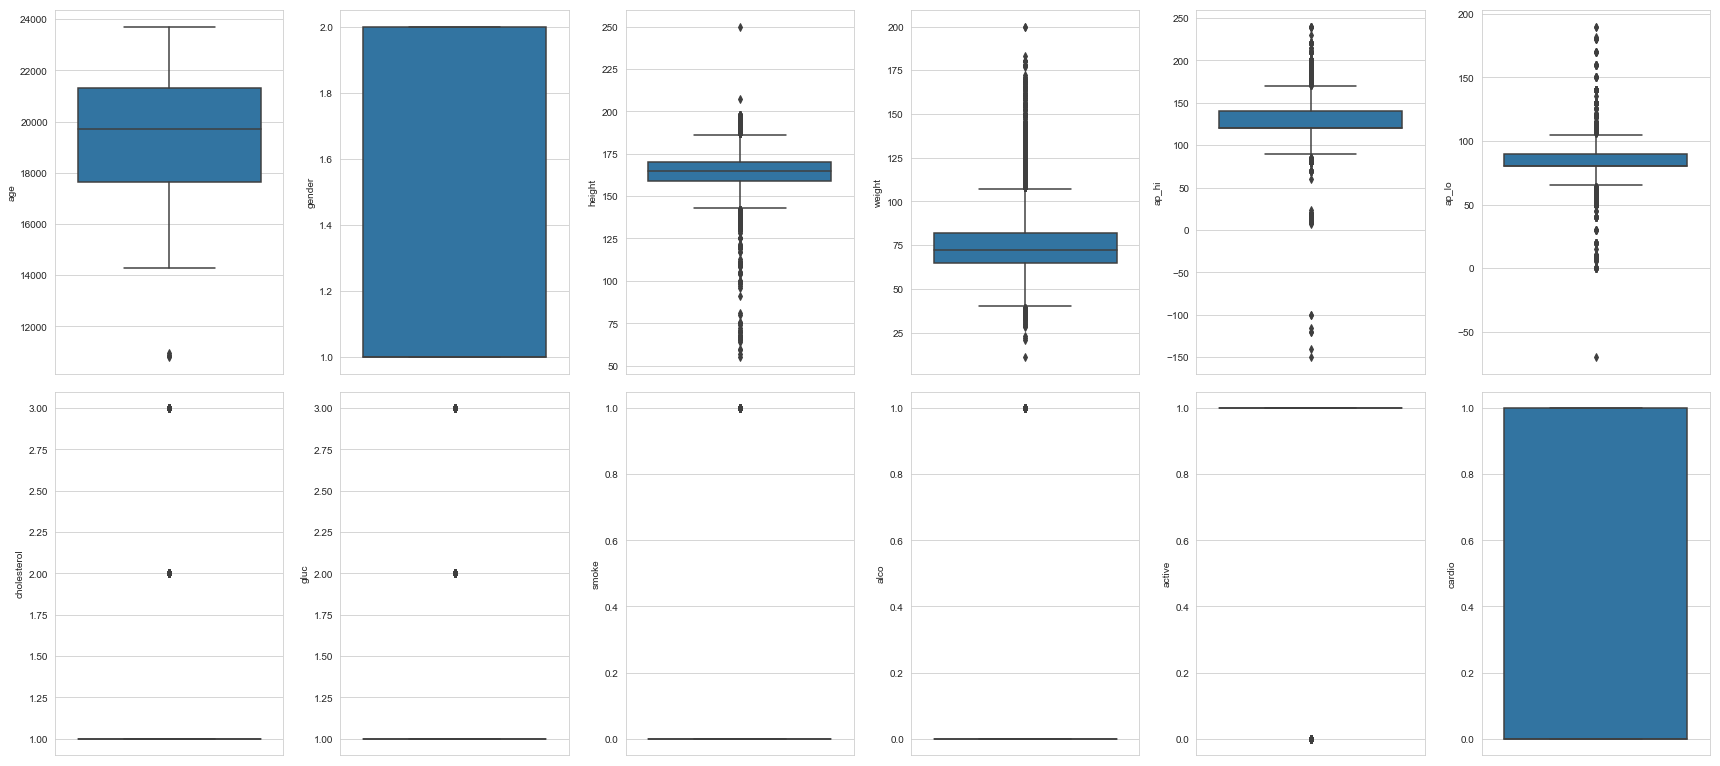

In [10]:
check_outliers(cleaned_df)

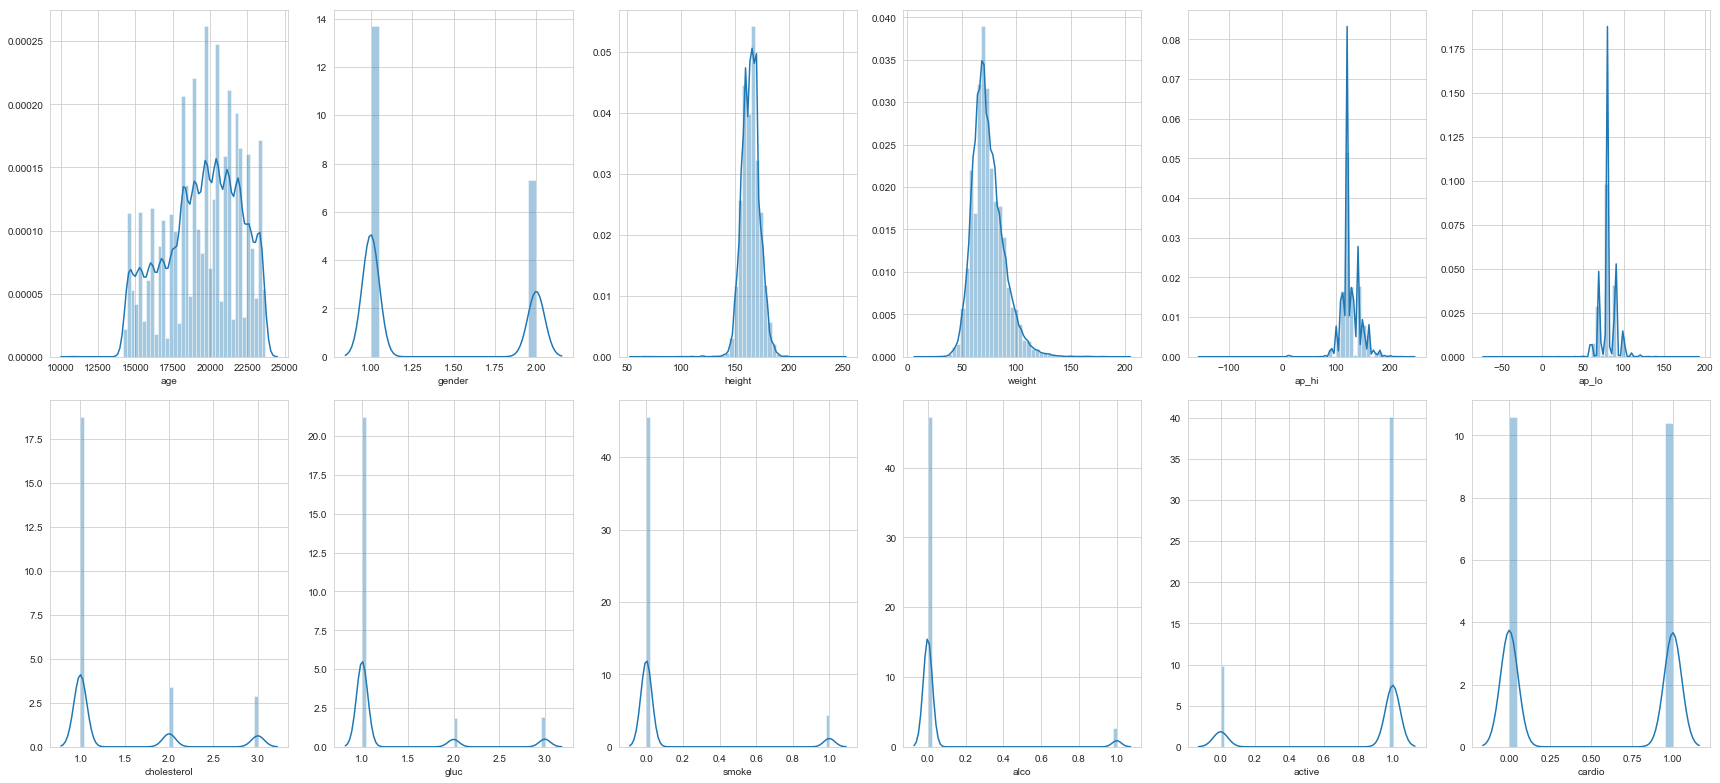

In [11]:
check_dist(cleaned_df)

Note that we're dealing with a mix of continuous, ordinal, and binary data. We can combine all of these types of data in one model - here are a few typical steps I'll take to preprocess this data before modeling.

- Standardize all continuous features: All continuous input should be standardized - for every continuous feature, compute its mean (𝜇) and standard deviation (𝜎) and do 𝑥 = (𝑥−𝜇) / 𝜎.
- Binarize categorical/discrete features (make dummy vars): For all categorical features, represent them as multiple boolean features. For example, instead of having one feature called cholesterol, have 3 boolean features - chol_normal, chol_above_normal, chol_well_above_normal and appropriately set these features to 0 or 1. As you can see, for every categorical feature, you are adding k binary feature where k is the number of values that the categorical feature takes.

In [37]:
cont_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
ord_cols = ['cholesterol', 'gluc']
bin_cols = ['gender', 'smoke', 'alco', 'active', 'cardio']

# create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# create an object to transform the data to fit minmax processor
df_scaled = min_max_scaler.fit_transform(cleaned_df[cont_cols])

# run the normalizer on the dataframe
df_normalized = pd.DataFrame(df_scaled)
df_normalized.columns = cont_cols
df_normalized.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,height,weight,ap_hi,ap_lo
0,0.588076,0.579487,0.269841,0.666667,0.576923
1,0.730159,0.517949,0.391534,0.743590,0.615385
2,0.624003,0.564103,0.280423,0.717949,0.538462
3,0.528455,0.584615,0.375661,0.769231,0.653846
4,0.516918,0.517949,0.238095,0.641026,0.500000


In [38]:
for col in ord_cols:
    dummies = pd.get_dummies(cleaned_df[col])
    dummies.columns = ['{0}_{1}'.format(col, ind) for ind in dummies.columns]
#     print(df_normalized.shape)
#     print(dummies.shape)
    df_normalized = pd.concat([df_normalized, dummies], axis=1)
    
df_normalized.head()

,age,height,weight,ap_hi,ap_lo,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0.588076,0.579487,0.269841,0.666667,0.576923,1.0,0.0,0.0,1.0,0.0,0.0
1,0.730159,0.517949,0.391534,0.743590,0.615385,0.0,0.0,1.0,1.0,0.0,0.0
2,0.624003,0.564103,0.280423,0.717949,0.538462,0.0,0.0,1.0,1.0,0.0,0.0
3,0.528455,0.584615,0.375661,0.769231,0.653846,1.0,0.0,0.0,1.0,0.0,0.0
4,0.516918,0.517949,0.238095,0.641026,0.500000,1.0,0.0,0.0,1.0,0.0,0.0


In [39]:
df_normalized = pd.concat([df_normalized, cleaned_df[bin_cols]], axis=1)
df_normalized['gender'] -= 1
df_normalized.head()

,age,height,weight,ap_hi,ap_lo,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,gender,smoke,alco,active,cardio
0,0.588076,0.579487,0.269841,0.666667,0.576923,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.730159,0.517949,0.391534,0.743590,0.615385,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,1.0
2,0.624003,0.564103,0.280423,0.717949,0.538462,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0
3,0.528455,0.584615,0.375661,0.769231,0.653846,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.516918,0.517949,0.238095,0.641026,0.500000,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [42]:
# try SVM
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

df_normalized= df_normalized.dropna()
print(df_normalized.shape)
X = df_normalized.drop('cardio', axis=1)
y = df_normalized['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42) # 80% training and 20% test

(68030, 16)


In [16]:
# create a svm classifier
clf = svm.SVC() # rbf kernel
# train the model using the training sets
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
# evaluate the model
def evaluate_model(clf, X_test, y_test):

    # predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))
    
    # calc auc
#     probas = clf.predict_proba(X_test)
#     auc = roc_auc_score(testy, probs)
#     print('AUC: %.3f' % auc)

In [20]:
evaluate_model(clf, X_test, y_test)

Accuracy: 0.601719829486991
Precision: 0.6701488639331418
Recall: 0.38173162749181794


In [43]:
# try RF
from sklearn.ensemble import RandomForestClassifier

# create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

# train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
evaluate_model(rf_clf, X_test, y_test)

# get feature importances
feature_imp = pd.Series(rf_clf.feature_importances_,index=X_test.columns).sort_values(ascending=False)
feature_imp

Accuracy: 0.5585036013523446
Precision: 0.557136007671408
Recall: 0.5185956560547456


age              0.363720
weight           0.225461
height           0.189890
ap_hi            0.086185
ap_lo            0.057651
cholesterol_1    0.022658
cholesterol_3    0.018811
gender           0.007127
active           0.006112
cholesterol_2    0.005404
alco             0.004680
smoke            0.004285
gluc_1           0.003630
gluc_3           0.002389
gluc_2           0.001996
dtype: float64